In [1]:
import numpy as np
import matplotlib.pyplot as plt
import sys
from matplotlib.patches import Rectangle
import time
from pathlib import Path
import cv2
from copy import deepcopy
import logging
from time import strftime
import os
import shutil

### 定义数据结构

In [2]:
class Point:
    def __init__(self, x, y, cost=sys.maxsize):
        self.x = x
        self.y = y
        self.cost = cost
        self.seen = False

In [3]:
def maybe_mkdir(dirpath):
    if not Path(dirpath).exists():
        Path(dirpath).mkdir(parents=True)
        
        
def clear_dir(dirpath):
    if Path(dirpath).exists():
        for f in Path(dirpath).iterdir():
            if f.is_file():
                f.unlink()
            if f.is_dir():
                try:
                    f.rmdir()  # pathlib删除非空文件夹会出错
                except OSError as err:
                    shutil.rmtree(dirpath)

### logger

In [4]:
# 设置日志格式#和时间格式
FMT = '%(asctime)s %(filename)s [line:%(lineno)d] %(levelname)s: %(message)s'
DATEFMT = '%Y-%m-%d %H:%M:%S'
PATH = os.path.abspath('.') + '/logs/'

class MyLog:
    def __init__(self, logname='AStar') -> None:
        maybe_mkdir(PATH)
        
        self.logger = logging.getLogger(logname)
        self.formatter = logging.Formatter(fmt=FMT, datefmt=DATEFMT)
        self.log_filename = '{0}{1}.log'.format(PATH, strftime("%Y-%m-%d"))
        if Path(self.log_filename).exists():
            Path(self.log_filename).unlink()

        # 创建一个StreamHandler,用于输出到控制台
        ch = self.get_console_handler()
        self.logger.addHandler(ch)

        # 创建一个FileHandler，用于写到本地
        fh = self.get_file_handler(self.log_filename)
        self.logger.addHandler(fh)

        # 设置日志的默认级别
        self.logger.setLevel(logging.DEBUG)

        # 这两行代码是为了避免日志输出重复问题
        self.logger.removeHandler(ch)
        # self.logger.removeHandler(fh)

    # 输出到文件handler的函数定义
    def get_file_handler(self, filename):
        filehandler = logging.FileHandler(filename, encoding="utf-8")
        filehandler.setFormatter(self.formatter)
        return filehandler

    # 输出到控制台handler的函数定义
    def get_console_handler(self):
        console_handler = logging.StreamHandler(sys.stdout)
        console_handler.setFormatter(self.formatter)
        return console_handler

### 建图

In [5]:
class RandomMap:
    def __init__(self, size, set_obstacle=True):
        self.size = size
        self.obstacle = size//4
        self.obstacle_point = []
        if set_obstacle:
            self.GenerateObstacle()

    def GenerateObstacle(self):
        
        self.obstacle_point.append(Point(self.size//2, self.size//2))
        self.obstacle_point.append(Point(self.size//2, self.size//2-1))

        # Generate an obstacle in the middle
        for i in range(self.size//2, self.size//2):
            self.obstacle_point.append(Point(i, self.size-i))
            self.obstacle_point.append(Point(i, self.size-i-1))
            self.obstacle_point.append(Point(self.size-i, i))
            self.obstacle_point.append(Point(self.size-i, i-1))

        for i in range(self.obstacle-1): 
            x = np.random.randint(0, self.size)
            y = np.random.randint(0, self.size)
            self.obstacle_point.append(Point(x, y))

            if (np.random.rand() > 0.5):
                for l in range(self.size//4):
                    self.obstacle_point.append(Point(x, y+l))
                    pass
            else:
                for l in range(self.size//4):
                    self.obstacle_point.append(Point(x+l, y))
                    pass

    def IsObstacle(self, i ,j): 
        for p in self.obstacle_point:
            if i==p.x and j==p.y:
                return True
        return False

### 优先队列

In [6]:
class MinPriorityQueue:
    def __init__(self) -> None:
        self.i = -1
        self.queue = []

    def _compare(self, i, j):
        p1 = self.queue[i]
        p2 = self.queue[j]
        return p1.cost < p2.cost
    
    def _exchange(self, i, j):
        self.queue[i], self.queue[j] = self.queue[j], self.queue[i]

    def _swim(self, k):
        if k <= 0:
            return

        if k > self.i:
            raise IndexError(f"k should in range [0, {self.i}], but got {k}")
        
        while (k - 1) >= 0 and (k - 1) // 2 >= 0:
            parent = (k - 1) // 2
            if self._compare(k, parent):
                self._exchange(k, parent)
                k = parent
            else:
                break

    def _sink(self, k):
        if k < 0 or k > self.i:
            raise IndexError(f"k should in range [0, {self.i}], but got {k}")
        while (2 * k + 1) <= self.i:
            left_child = 2 * k + 1
            if left_child + 1 <= self.i and self._compare(left_child+1, left_child):
                min_child = left_child + 1
            else:
                min_child = left_child

            if self._compare(min_child, k):
                self._exchange(min_child, k)
                k = min_child
            else:
                break
            
    def insert(self, p:Point):
        if self.i < 0:
            self.queue.append(p)
            self.i += 1
        else:
            self.queue.append(p)
            self.i += 1
            self._swim(self.i)

    def pop(self):
        if self.i == 0:
            self.i -= 1
            res = self.queue[0]
            del self.queue[0]
            return res
        
        if self.i > 0:
            assert self.i == len(self.queue) - 1
            res = self.queue[0]
            self._exchange(0, self.i)
            del self.queue[-1]
            self.i -= 1
            self._sink(0)
            return res

    def is_empty(self):
        """
        Outputs:
            True: 队列为空
            False: 队列不为空
        """
        return self.i < 0

    def build_from_list(self, points):
        for p in points:
            assert isinstance(p, Point)
            self.insert(p)

    def _check_is_min_priority_queue(self):
        for i in range(len(self.queue) // 2):
            left_child = 2 * i + 1
            assert self.queue[i].cost <= self.queue[left_child].cost, f"i = {i}, parent = {self.queue[i].cost}, left_child = {self.queue[left_child].cost}"
            if left_child + 1 <= self.i:
                assert self.queue[i].cost <= self.queue[left_child+1].cost, f"i = {i}, parent = {self.queue[i].cost}, right_child = {self.queue[left_child+1].cost}"

    def clear(self):
        self.queue.clear()
        self.i = -1


In [7]:
dis = np.random.randint(0, 5, 15)
queue = MinPriorityQueue()
for d in dis:
    p = Point(0, 0)
    p.cost = d
    queue.insert(p)

In [8]:
queue._check_is_min_priority_queue()

### AStar

In [9]:
class AStar:
    def __init__(self, map_size=5, set_obstacle=True) -> None:
        self.fig, self.ax = plt.subplots(1, 1, figsize=[12, 12])

        self.logger = MyLog().logger
        
        self.map_size = map_size
        self.map = RandomMap(size=map_size, set_obstacle=set_obstacle)
        self.build_total_points()
        self.queue = MinPriorityQueue()
        
        self.sample_start_end_point()
        
        background = np.ones((map_size+1, map_size+1, 3), dtype=np.uint8) * 255
        self.ax.imshow(background)
        for obs in self.map.obstacle_point:
            self.plot(obs, 'k')
        self.plot(self.start, 'b')
        self.plot(self.end, 'r')

        self.open_set = self.queue.queue
        self.close_set = []
        
        clear_dir('./result')
        
    def sample_start_end_point(self):
        coords = np.arange(self.map_size)
        points = []
        
        while True:
            ls = [np.random.choice(coords, replace=True) for _ in range(2)]
            p = Point(ls[0], ls[1])
            if self.is_valid_point(p):
                points.append(ls)
                break

        while True:
            ls = [np.random.choice(coords, replace=True) for _ in range(2)]
            p = Point(ls[0], ls[1])
            if p.x != points[0][0] and p.y != points[0][1] and self.is_valid_point(p):
                points.append(ls)
                break
                
        print(f"start: ({points[0][0]}, {points[0][1]})")
        print(f"end:   ({points[1][0]}, {points[1][1]})")
        self.set_start_point(*points[0])
        self.set_end_point(*points[1])
        
    def plot(self, p, color, s=None):
        rec = Rectangle((p.x, p.y), 1, 1, color=color)
        self.ax.add_patch(rec)
        if s is not None:
            fontdict = {'fontsize': 7, 'fontweight': 'bold'}
            txt = self.ax.text(p.x+0.5, p.y+0.5, s, fontdict=fontdict)

    def build_total_points(self):
        y, x = np.meshgrid(np.arange(self.map_size), np.arange(self.map_size), indexing='ij')
        grid = np.stack((x, y), -1)
        self.points = []
        for i in range(self.map_size):
            for j in range(self.map_size):
                p = Point(grid[i, j, 0], grid[i, j, 1])
                self.points.append(p)
    
    @staticmethod
    def manhattan_distance(p1, p2):
        return np.abs(p1.x - p2.x) + np.abs(p1.y - p2.y)
    
    @staticmethod
    def euclidean_distance(p1, p2):
        return np.sqrt(np.power(p1.x - p2.x, 2) + np.power(p1.y - p2.y, 2))
    
    @staticmethod
    def diagonally_distance(p1, p2):
        """
        如果上下左右平移则相当于计算曼哈顿距离，如果对角平移则计算对角距离
        """
        diff_x = np.abs(p1.x - p2.x)
        diff_y = np.abs(p1.y - p2.y)
        return np.round((diff_x + diff_y) + (np.sqrt(2) - 2) * min(diff_x, diff_y), 5)
        
    def base_distance(self, p):
        return self.diagonally_distance(p, self.start)
        # return self.euclidean_distance(p, self.start)

    def heuristic_distance(self, p):
        return self.diagonally_distance(p, self.end)    
        # return self.euclidean_distance(p, self.end)

    def set_start_point(self, x, y):
        self.start = Point(x, y, 0)
        self.points[self.start.y * self.map_size + self.start.x].cost = 0
        self.queue.clear()
        self.queue.insert(self.start)

    def set_end_point(self, x, y):
        self.end = Point(x, y)

    def is_start_point(self, p):
        return (p.x == self.start.x) and (p.y == self.start.y)

    def is_end_point(self, p):
        return (p.x == self.end.x) and (p.y == self.end.y)
    
    def is_valid_point(self, p):
        if not self.map.IsObstacle(p.x, p.y) and 0 <= p.x < self.map_size and 0 <= p.y < self.map_size:
            return True
        else:
            return False
    
    def get_neibors(self, p):
        x_offset = [-1, -1, -1, 0, 0, 1, 1, 1]
        y_offset = [-1, 0, 1 ,-1, 1, -1, 0, 1]
        neighbors = []
        for xo, yo in zip(x_offset, y_offset):
            n = Point(p.x+xo, p.y+yo)
            if self.is_valid_point(n):
                neighbors.append(self.points[n.y * self.map_size + n.x])
        return neighbors
    
    def get_index_in_set(self, p, point_set):
        for i, point in enumerate(point_set):
            if p.x == point.x and p.y == point.y:
                return i
    
    def is_in_open_set(self, p):
        for i, point in enumerate(self.open_set):
            if p.x == point.x and p.y == point.y:
                return True
        return False

    def is_in_close_set(self, p):
        return self.points[p.y * self.map_size + p.x].seen

    def build_path(self):
        final = [self.end]
        cur = self.points[self.end.y * self.map_size + self.end.x].parent
        while not self.is_start_point(cur):
            self.logger.debug(f"Point({cur.x}, {cur.y})")
            final.append(cur)
            cur = cur.parent
            
        for p in final:
            if self.is_start_point(p):
                color = 'b'
            elif self.is_end_point(p):
                color = 'r'
            else:
                color = 'g'
            self.plot(p, color)
            
        plt.tight_layout()
        plt.savefig('./result/final.jpg', dpi=95)
        
    def update_status(self, p, cost=None, parent=None, seen=None):
        i = p.y * self.map_size + p.x
        if cost is not None:
            self.points[i].cost = cost
        if parent is not None:
            self.points[i].parent = parent
        if seen is not None:
            self.points[i].seen = seen

    def save_image(self, p=None, s=None):        
        if p is not None:
            if self.is_start_point(p):
                color = 'b'
            elif self.is_end_point(p):
                color = 'r'
            else:
                color = 'c'
            
            self.plot(p, color, s=s)

        if not Path('./result/').exists():
            Path('./result/').mkdir(parents=True)
        
        plt.tight_layout()
        plt.savefig(str(Path('./result') / f'{str(time.time())}.jpg'), dpi=95)
        
    def move(self, p):
        self.logger.debug(f"{'=' * 100}")
        index = p.y * self.map_size + p.x
        self.logger.debug(f"Parent ({p.x}, {p.y}) parent_cost: {self.points[index].cost} ")
        neibors = self.get_neibors(p)
        for n in neibors:
            if self.is_end_point(n):
                self.update_status(self.end, parent=p)
                return True
            
            if self.is_in_close_set(n):
                continue
            
            cur_cost = self.base_distance(n) + self.heuristic_distance(n) * 10
            self.logger.debug(f"\tPoint({n.x}, {n.y}) new_cost: {cur_cost} org_cost: {n.cost}")
            if self.is_in_open_set(n):
                in_open_set_i = self.get_index_in_set(n, self.open_set)
                if self.open_set[in_open_set_i].cost > cur_cost:
                    self.logger.debug(f"\t->Update Point({self.open_set[in_open_set_i].x}, {self.open_set[in_open_set_i].y})'s cost from {self.open_set[in_open_set_i].cost} to {cur_cost}, updata Parent from Point({self.open_set[in_open_set_i].parent.x}, {self.open_set[in_open_set_i].parent.y}) to Point({p.x}, {p.y})")
                    # 更新open_set
                    self.open_set[in_open_set_i].cost = cur_cost
                    self.queue._swim(in_open_set_i)
                    # 更新总points列表对应的point状态和属性
                    self.update_status(n, cost=cur_cost, parent=p)
                    
                continue
            
            if cur_cost < n.cost:
                self.update_status(n, parent=p, cost=cur_cost)
                self.logger.debug(f"\tUpdate Point({n.x}, {n.y}), Cost {cur_cost}")
                self.queue.insert(self.points[n.y * self.map_size + n.x])
                self.logger.debug(f"\tinsert queue: ({n.x}, {n.y}) cost {n.cost}; top queue: ({self.open_set[0].x}, {self.open_set[0].y}) cost {self.open_set[0].cost}")
        return False
    
    def main(self):
        i = 1
        while not self.queue.is_empty():
            cur = self.queue.pop()                
            if self.is_in_close_set(cur):
                continue

            self.update_status(cur, seen=True)
            
            self.save_image(cur, s=str(i))
            i += 1
            
            if self.move(cur):
                break
                
        self.save_image(self.end)
        self.build_path()

start: (3, 8)
end:   (19, 48)


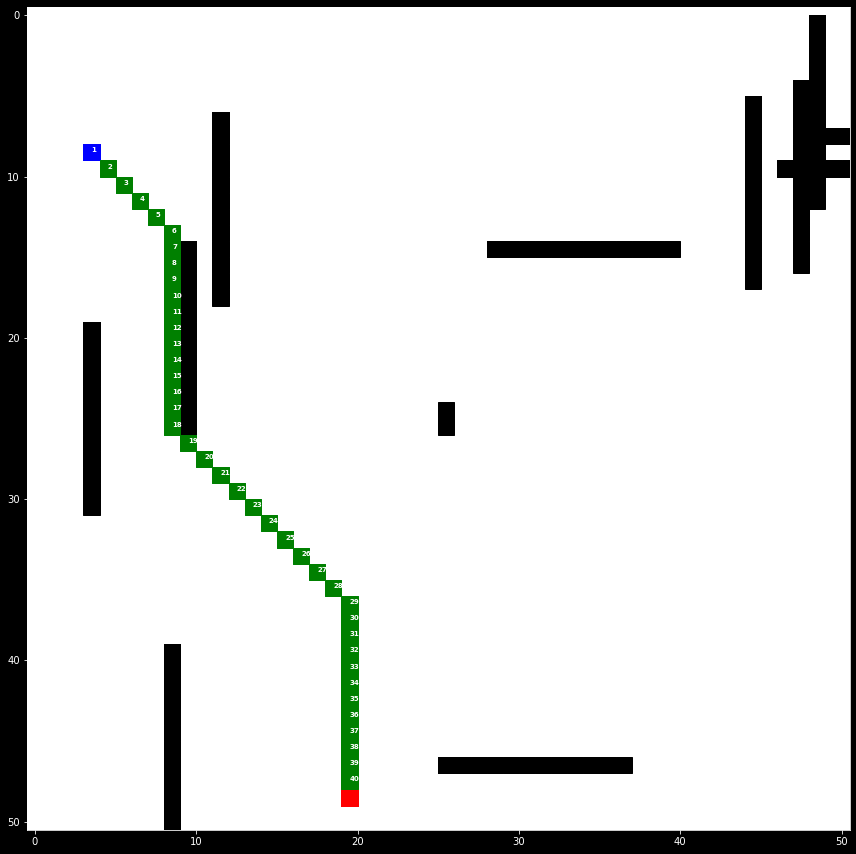

In [10]:
np.random.seed(7)
map_size = 50
alg = AStar(map_size, True)
alg.main()

In [11]:
!convert ./result/*.jpg ./astar.gif